<a href="https://colab.research.google.com/github/akashjborah97/Covid-Protocol-Detection-System/blob/main/Vedio_detection_of_mask_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import the necessary packages

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream

import numpy as np
import imutils
import time
import cv2
import os
from itertools import combinations
import math

# import dependencies for colab webcam
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html

#Centroid Tracker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict

In [ ]:
class CentroidTracker:
    def __init__(self, maxDisappeared=50, maxDistance=50):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.bbox = OrderedDict()  # CHANGE

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared

        # store the maximum distance between centroids to associate
        # an object -- if the distance is larger than this maximum
        # distance we'll start to mark the object as "disappeared"
        self.maxDistance = maxDistance

    def register(self, centroid, inputRect):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.bbox[self.nextObjectID] = inputRect  # CHANGE
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
        del self.bbox[objectID]  # CHANGE

    def update(self, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1

                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            # return early as there are no centroids or tracking info
            # to update
            # return self.objects
            return self.bbox

        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
        inputRects = []
        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)
            inputRects.append(rects[i])  # CHANGE

        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i], inputRects[i])  # CHANGE

        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value as at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()

            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                if row in usedRows or col in usedCols:
                    continue

                # if the distance between centroids is greater than
                # the maximum distance, do not associate the two
                # centroids to the same object
                if D[row, col] > self.maxDistance:
                    continue

                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.bbox[objectID] = inputRects[col]  # CHANGE
                self.disappeared[objectID] = 0

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1

                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)

            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col], inputRects[col])

        # return the set of trackable objects
        # return self.objects
        return self.bbox


In [ ]:
tracker = CentroidTracker(maxDisappeared=80, maxDistance=90)

##Non Max Supression

In [ ]:
def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))

# Defining functions for face and mask detection

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):


	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)




	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)


In [ ]:
def detect_face(frame,faceNet):
  # grab the dimensions of the frame and then construct a blob
	# from it
  (h, w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)

  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the detection'
    confidence = detections[0, 0, i, 2]
    if confidence < 0.5:
      return 0
    else:
      return 1


In [ ]:
def measure_distance(frame,faceNet):
  (h, w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)

  # loop over the detections
  for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
    confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
    if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
      face = frame[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
      faces.append(face)
      locs.append((startX, startY, endX, endY))  

# only make a predictions if at least one face was detected
  if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
    faces = np.array(faces, dtype="float32")
    preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
  return (locs, preds)


#Loading the face detector model and mask detector model

In [ ]:
# load our serialized face detector model from disk

prototxtPath = r"/content/drive/MyDrive/face mask detection/face_detector/deploy.prototxt"
weightsPath = r"/content/drive/MyDrive/face mask detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("/content/drive/MyDrive/face mask detection/mask_detector.model")


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#Performing face mask detection 


[INFO] starting video stream...


<IPython.core.display.Javascript object>

(1, 1, 200, 7)
(1, 1, 200, 7)


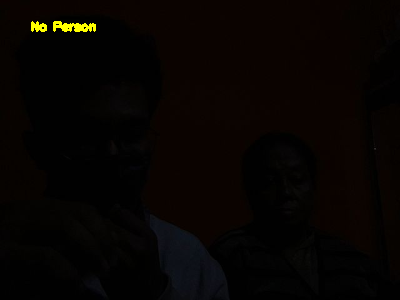

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 1s 910ms/step


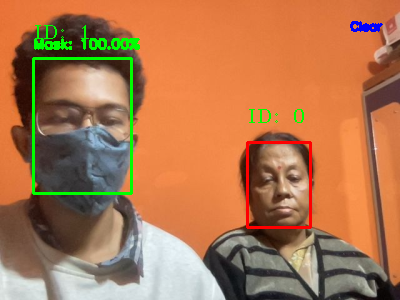

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 88ms/step


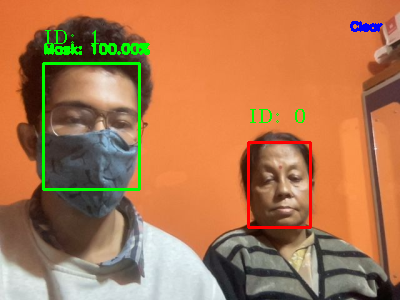

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 165ms/step


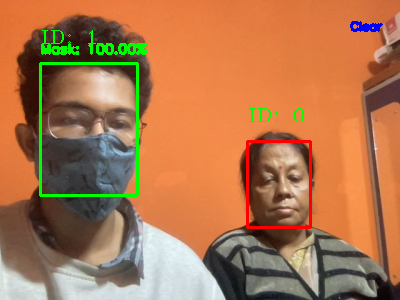

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 80ms/step


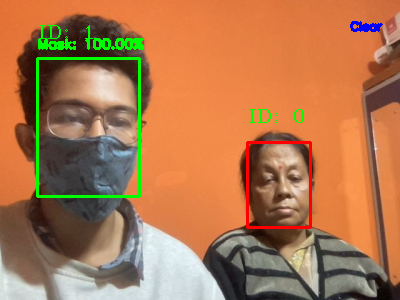

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 81ms/step


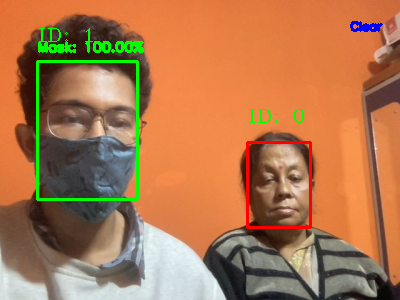

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 91ms/step


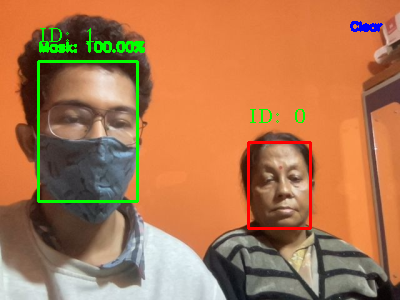

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 81ms/step


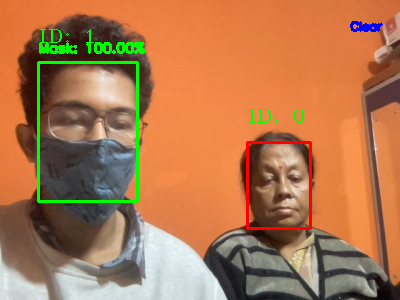

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 83ms/step


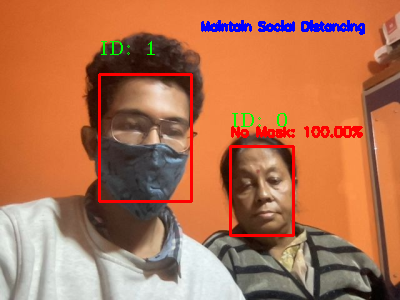

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 82ms/step


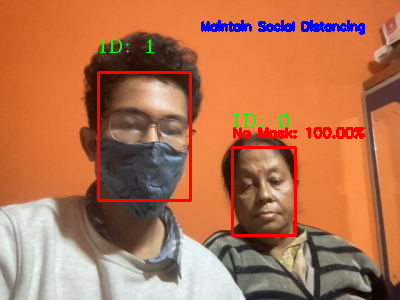

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 87ms/step


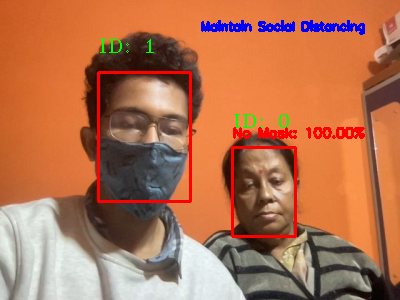

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 83ms/step


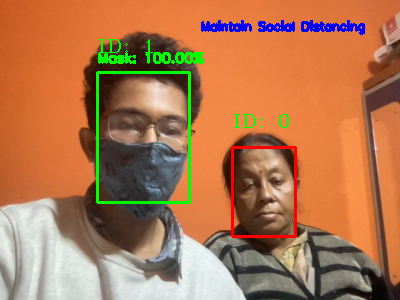

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 213ms/step


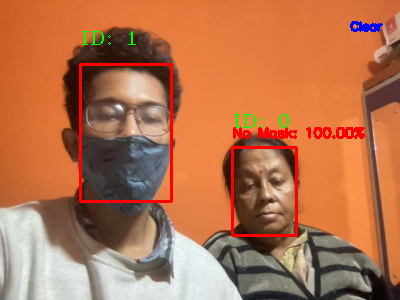

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 206ms/step


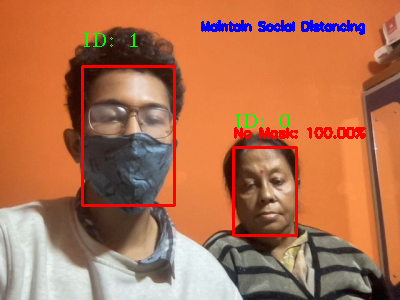

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 98ms/step


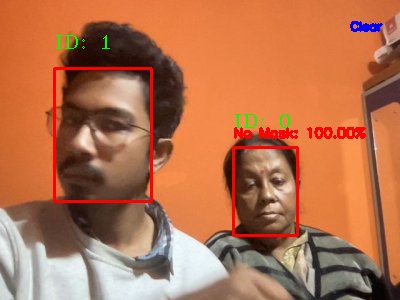

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 79ms/step


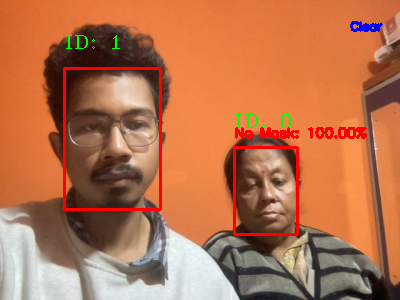

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 155ms/step


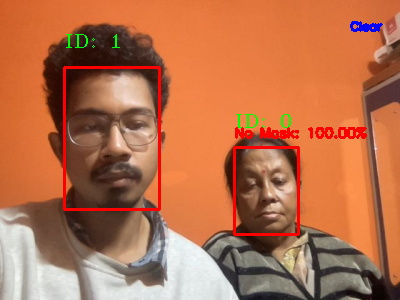

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 79ms/step


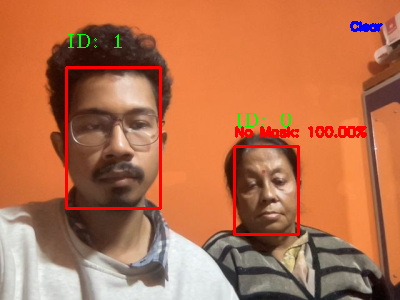

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 79ms/step


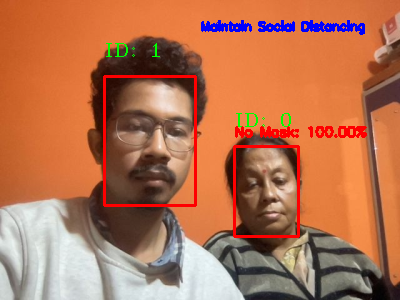

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 149ms/step


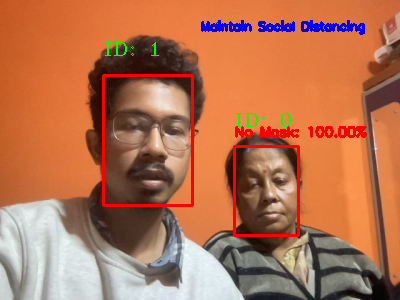

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 77ms/step


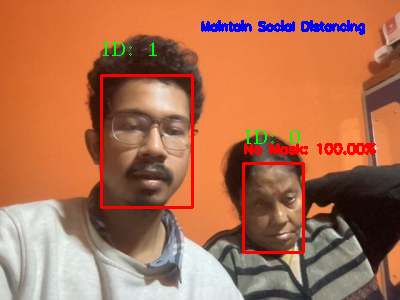

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 78ms/step


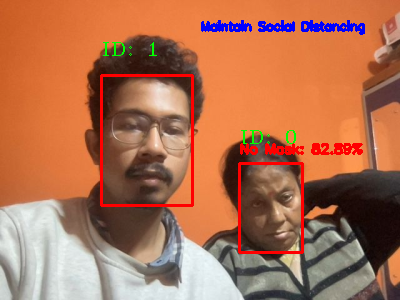

In [ ]:
# initialize the video stream
print("[INFO] starting video stream...")
cap=video_stream()

# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
# bbox = ''
count = True
bbox=''
img_array = []
centroid_dict = dict()

		# loop over the frames from the video stream

while True:

	js_reply = video_frame(label_html, bbox)
	if not js_reply:
		 break
		

	# convert JS response to OpenCV Image
	img = js_to_image(js_reply["img"])
	img = imutils.resize(img, width=400)

	#displaying "No Person" when no person in the vedio
	#detect person is present or not
	presence=detect_face(img,faceNet)
	if presence==0:
		cv2.putText(img, "No Person", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.40, (0, 255, 255), 2)
 
		# detect faces in the frame and determine if they are wearing a face mask or not
	(locs, preds) = detect_and_predict_mask(img, faceNet, maskNet)
	

	rects=[]
	# centroid_dict = dict()
	# loop over the detected face locations and their corresponding locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred
		rects.append(box)
	
	boundingboxes = np.array(rects)
	boundingboxes = boundingboxes.astype(int)
	rects = non_max_suppression_fast(boundingboxes, 0.3)

	objects = tracker.update(rects)
	for (objectId, bbox) in objects.items():
		x1, y1, x2, y2 = bbox
		x1 = int(x1)
		y1 = int(y1)
		x2 = int(x2)
		y2 = int(y2)
		cX = int((x1+x2)/2.0)
		cY = int((y1+y2)/2.0)


		centroid_dict[objectId] = (cX, cY, x1, x2, y1, y2)
		cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

		text = "ID: {}".format(objectId)
		cv2.putText(img, text, (x1, y1-20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0), 1)

# determine the class label and color we'll use to draw the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	

# display the label and bounding box rectangle on the output
# frame
		cv2.putText(img, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
	


#displaying ”Maintain Social Distancing” when two persons are standing close enough.

	red_zone_list = []
	for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
		dx, dy = p1[0] - p2[0], p1[1] - p2[1]
		distance = math.sqrt(dx * dx + dy * dy)
		if distance < 150.0:
			if id1 not in red_zone_list:
				red_zone_list.append(id1)
			if id2 not in red_zone_list:
				red_zone_list.append(id2)

	# print(red_zone_list[0])

	for id, box in centroid_dict.items():
		if id in red_zone_list:
			cv2.putText(img, "Maintain Social Distancing", (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.40, (255, 0, 0), 2)
		else:
			cv2.putText(img, "Clear", (350, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.40, (255, 0, 0), 2)
			







# show the output frame
	from google.colab.patches import cv2_imshow
	cv2_imshow(img)
	img_array.append(img)
	key = cv2.waitKey(1) & 0xFF


	if key == ord("q"):
				break

In [ ]:
# Read until video is completed
bbox=''
while(cap):
  # Capture frame-by-frame
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
		 break
  img = js_to_image(js_reply["img"])
    
  if img == True:
    
    # Write the frame to the output files
    out_avi.write(img)
    out_mp4.write(img)
    
  # Break the loop
  else: 
    break

# Writing photos to vedio

In [ ]:
for i in range(len(img_array)):
  cv2.imwrite('img'+str(i)+'.jpg',img_array[i])
print("photos exported successfully")

photos exported successfully


In [ ]:
#making the vedio
import cv2
import numpy as np
import glob

frameSize = (400, 300)

out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

for filename in glob.glob('/content/drive/MyDrive/face mask detection/photos captued/*.jpg'):
    img = cv2.imread(filename)
    out.write(img)

out.release()
print("Video made successfully")

Video made successfully
